## OpenCV

##### After augmentation, images store in data folder

In [47]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from collections import defaultdict
from PIL import Image
import numpy as np
import cv2

In [48]:
input_dir = "./data/train"
output_dir = "./data/train_data_argumentatitons"
train_images = glob(input_dir + "/*/*")

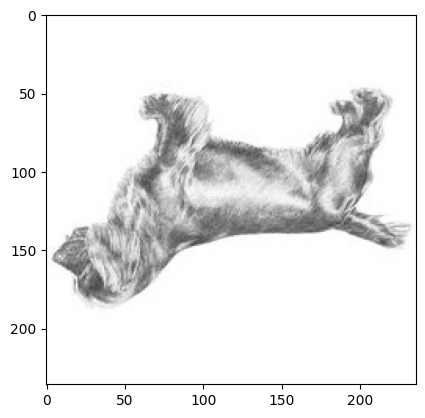

In [44]:
# img_path = './data/train/../..' 경로 직접 지정 가능
img = cv2.imread(np.random.choice(train_images))
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


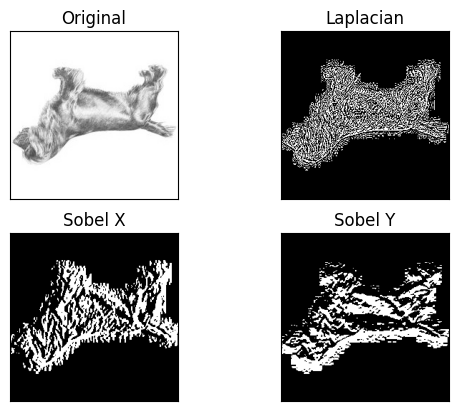

In [45]:
# Augmentation Example
laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
 
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
 
plt.show()

In [50]:
# Apply transformations to all train data and create data_augmented folder
# Note: This process may take a long time depending on the situation.

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
  
def apply_transformations(img):
    """
    Apply Laplacian, Sobel X, and Sobel Y transformations to the input image.
    
    Parameters:
    img (numpy.ndarray): Input grayscale image.
    
    Returns:
    numpy.ndarray: Image with Laplacian, Sobel X, and Sobel Y transformations applied.
    """
    # Apply Laplacian transformation
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)
    
    # Apply Sobel X transformation
    sobelx = cv2.Sobel(laplacian, cv2.CV_64F, 1, 0, ksize=5)
    sobelx = cv2.convertScaleAbs(sobelx)
    
    # Apply Sobel Y transformation
    sobely = cv2.Sobel(sobelx, cv2.CV_64F, 0, 1, ksize=5)
    transformed_img = cv2.convertScaleAbs(sobely)
    
    return transformed_img


# transform from all train images to augmentation images 
for i, img_path in enumerate(train_images):
    # Load the image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        continue
    
    # Apply transformations
    transformed_img = apply_transformations(img)

    # Generate output file names
    base_name = os.path.basename(img_path)
    name, ext = os.path.splitext(base_name)

    # Save the original image in the same output directory
    original_output_path = os.path.join(output_dir, f'{name}_original{ext}')
    cv2.imwrite(original_output_path, img)
    
    # Save the transformed image with the same name as the original
    transformed_output_path = os.path.join(output_dir, f'{name}_transformed{ext}')
    cv2.imwrite(transformed_output_path, transformed_img)
    
    if (i+1) % 1000 == 0:
        print(f'[{i+1}/{len(train_images)}] Processing....')

print("Image augmentation completed and saved to", output_dir)


[1000/15021] Processing....
[2000/15021] Processing....
[3000/15021] Processing....
[4000/15021] Processing....
[5000/15021] Processing....
[6000/15021] Processing....
[7000/15021] Processing....
[8000/15021] Processing....
[9000/15021] Processing....
[10000/15021] Processing....
[11000/15021] Processing....
[12000/15021] Processing....
[13000/15021] Processing....
[14000/15021] Processing....
[15000/15021] Processing....
Image augmentation completed and saved to ./data/train_data_argumentatitons


## Torchvision.Transforms

#### After testing, the code add in select_transform.py

In [33]:
import torch
import torchvision.transforms as transforms
from PIL import Image

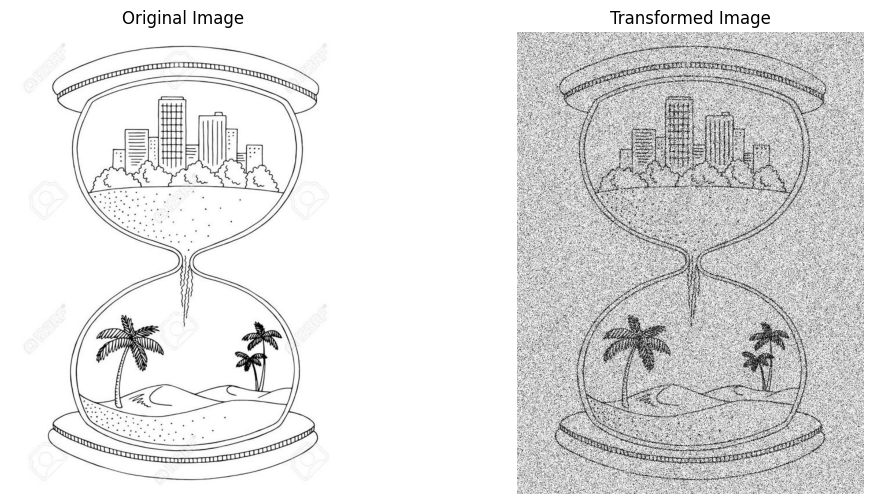

In [29]:
# Augmentation Example
# For other libraries, see the following links: https://pytorch.org/vision/0.9/transforms.html

# OpenCV image -> PIL image
img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        np_img = np.array(img)
        noise = np.random.normal(self.mean, self.std, np_img.shape)
        noisy_img = np_img + noise
        noisy_img = np.clip(noisy_img, 0, 255)  # Clip values to stay within [0, 255]
        return Image.fromarray(noisy_img.astype(np.uint8))

# Define various transformations
transform = transforms.Compose([
    transforms.ColorJitter(contrast=0.8),       # Adjust contrast
    AddGaussianNoise(mean=0.0, std=70.0),                # Add Gaussian noise
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.5)),  # Slight Gaussian blur
    transforms.Grayscale(num_output_channels=1), # Ensure grayscale
    transforms.ToTensor(),                      # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize
])

transformed_img = transform(img_pil)
transformed_img_pil = transforms.ToPILImage()(transformed_img)

# Display original and transformed images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(img_pil)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Transformed image
ax[1].imshow(transformed_img_pil, cmap='gray')
ax[1].set_title('Transformed Image')
ax[1].axis('off')

plt.show()

## Albumentations.Transforms

#### After testing, the code add in select_transform.py

In [32]:
import albumentations as A

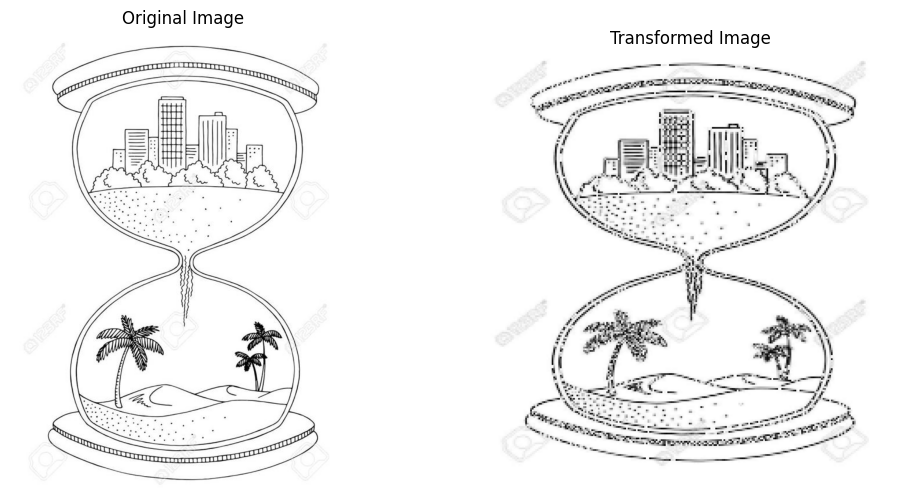

In [40]:
# Declare an augmentation
# For other libraries, see the following links: https://albumentations.ai/docs/getting_started/transforms_and_targets/
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.8, contrast_limit=0.2, p=0.5),  # Random brightness and contrast
    A.GaussianBlur(blur_limit=(3, 3), p=0.3),     # Slight Gaussian blur
    A.Resize(height=256, width=256),              # Resize to 256x256
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),  # Normalize
])

# Apply transformations
transformed  = transform(image=img)
transformed_img = transformed["image"]

# Convert the tensor back to a PIL image for display
transformed_img_pil = Image.fromarray((transformed_img * 255).astype(np.uint8))

# Display the original and transformed images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Transformed image
ax[1].imshow(transformed_img_pil, cmap='gray')
ax[1].set_title('Transformed Image')
ax[1].axis('off')

plt.show()
